In [1]:
dataset = "ALFTS"

In [2]:
from MRF import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
close_prices = pd.read_csv(f"/Users/ryanlucas/Desktop/MacroRandomForest/Datasets/ALFTS.csv")['spy_close']

In [5]:
data_in = pd.read_csv(f"/Users/ryanlucas/Desktop/MacroRandomForest/Datasets/ALFTS.csv")

In [6]:
rows_of_interest = 0

In [7]:
data_in = data_in.iloc[rows_of_interest:, 1:]
close_prices = close_prices.iloc[rows_of_interest:]

In [8]:
data_in = data_in.reset_index(drop = True)
close_prices = close_prices.reset_index(drop = True)

In [9]:
data_in.iloc[:, 1:11] = data_in.iloc[:, 1:11].diff()
data_in.iloc[:, 12:23] = data_in.iloc[:, 12:23].diff()
data_in.iloc[:, -1] = data_in.iloc[:, -1].diff()

In [10]:
data_in = data_in.fillna(0)

In [11]:
oos_pos = np.arange(data_in.index[-300], data_in.index[-1]+1)

In [12]:
data_in

,SPY_1d_returns,vix_spot,vix_1m,vix_2m,vix_3m,vix_4m,vix_5m,vix_6m,vix_7m,vix_8m,...,yc_2y,yc_3y,yc_5y,yc_7y,yc_10y,yc_20y,yc_30y,yc_slopes_1m_10y,yc_slopes_3m_10y,spread_3m_10y
0,0.042776,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000492,0.000502,0.00
1,-0.002086,-0.12,0.30,0.20,0.06,0.08,0.06,-0.04,-0.04,-0.05,...,0.00,0.03,0.05,0.06,0.06,0.07,0.08,0.000514,0.000522,0.06
2,0.004865,-0.73,-0.60,-0.25,-0.10,-0.19,-0.08,-0.16,-0.28,-0.20,...,0.00,0.01,0.01,0.01,0.01,0.00,-0.02,0.000519,0.000528,0.02
3,-0.003123,-0.04,-0.55,-0.25,-0.07,0.06,0.06,0.10,0.06,0.02,...,0.00,0.00,0.00,-0.01,-0.01,0.00,0.00,0.000517,0.000525,-0.01
4,-0.003242,-0.17,-0.10,0.01,-0.08,-0.12,-0.18,-0.17,-0.03,-0.06,...,-0.02,-0.03,-0.03,-0.03,-0.03,-0.04,-0.04,0.000507,0.000516,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,0.009911,-1.75,-1.00,-0.79,-0.65,-0.65,-0.60,-0.60,-0.63,-0.50,...,-0.02,-0.02,-0.02,-0.01,-0.02,-0.02,-0.02,0.000479,0.000488,-0.03
2113,-0.002125,0.44,-0.25,0.02,0.09,0.14,0.12,0.17,0.27,0.10,...,0.00,-0.02,-0.03,-0.05,-0.05,-0.06,-0.05,0.000461,0.000470,-0.05
2114,0.001877,-1.48,-0.95,-0.93,-0.69,-0.59,-0.46,-0.45,-0.44,-0.41,...,-0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.000468,0.000476,0.02
2115,0.001165,-0.62,-1.02,-0.95,-0.82,-0.68,-0.61,-0.51,-0.45,-0.36,...,0.00,0.00,0.01,0.04,0.03,0.03,0.02,0.000479,0.000487,0.03


In [13]:
MRF = MacroRandomForest(data = data_in,
                        y_pos = 0,
                        x_pos = np.arange(1,4), 
                        fast_rw = True, 
                        B = 30, 
                        mtry_frac = 0.25, 
                        resampling_opt = 2,
                        oos_pos = oos_pos, 
                        trend_push = 4,
                        quantile_rate = 0.3, 
                        print_b = True, 
                        parallelise = True)

In [14]:
mrf_output = MRF._ensemble_loop()

In [ ]:
def financial_evaluation(model_forecasts, close_prices, oos_pos):
    '''
    Method for generating signals and backtesting the financial performance of MRF
    '''

    daily_profit = []

    T_profit = np.arange(1, len(oos_pos)+1)

    for t in T_profit:

        # Produce a trading signal and calculate daily profit.
        daily_profit.append(trading_strategy(model_forecasts=model_forecasts,
                                                stock_price=close_prices,
                                                k=1,
                                                t=t))

    daily_profit = pd.Series(daily_profit)
    cumulative_profit = daily_profit.cumsum()
    annualised_return = get_annualised_return(
        cumulative_profit, T_profit)

    sharpe_ratio = get_sharpe_ratio(daily_profit)
    max_drawdown = get_max_dd_and_date(
        cumulative_profit)

    # Return the output.
    return daily_profit, cumulative_profit, annualised_return, sharpe_ratio, max_drawdown

def get_sharpe_ratio(daily_profit):
    mean = daily_profit.mean()
    std_dev = daily_profit.std()
    return 252**(0.5)*mean/std_dev


def get_max_dd_and_date(cumulative_profit):
    rolling_max = (cumulative_profit+1).cummax()
    period_drawdown = (
        ((1+cumulative_profit)/rolling_max) - 1).astype(float)
    drawdown = round(period_drawdown.min(), 3)
    return drawdown

def get_annualised_return(cumulative_profit, T_profit):
    return cumulative_profit.iloc[-1]*(252/len(T_profit))

def trading_strategy(model_forecasts, stock_price, t, k=1):

    PL_t = 0
    signal_t_minus_1 = 0

    # Long if return prediction > 0 ; otherwise short.
    for i in range(1, k+1):
        if model_forecasts.iloc[t-i] > 0:
            signal_t_minus_1 += 1
        elif model_forecasts.iloc[t-i] < 0:
            signal_t_minus_1 -= 1

    PL_t += (1/k)*signal_t_minus_1 * \
        ((stock_price[t] - stock_price[t-1])/stock_price[t-1])

    return PL_t

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

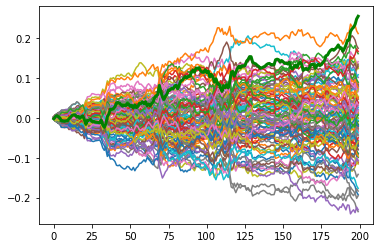

In [ ]:
fig, ax = plt.subplots()

for i in range(1, 100):
    financial_evaluation(pd.Series(np.random.normal(0, 1, size = len(oos_pos))), close_prices, oos_pos)[0].cumsum().plot(ax = ax)

MRF.financial_evaluation(close_prices)[0].cumsum().plot(ax = ax, linewidth = 3, color = 'green')

In [ ]:
mrf_output.keys()

dict_keys(['YandX', 'pred_ensemble', 'pred', 'S_names', 'betas', 'betas_draws_raw', 'betas_draws', 'model'])

In [ ]:
profile_code = False
if profile_code:
    %load_ext line_profiler
    %lprun -f MRF._splitter_mrf MRF._one_MRF_tree(1)

In [ ]:
phils_preds = pd.read_csv("/Users/ryanlucas/Desktop/MRF/predictions_s1.csv", index_col = "Unnamed: 0")

In [ ]:
my_preds = pd.DataFrame(mrf_output['pred_ensemble'])